In [24]:
import torch
import corner
import numpy as np
import pylab as plt
from swyft.intensity import BallMask, ComboMask, Prior1d, Prior, IntensityNew
from tqdm import tqdm
import swyft

DEVICE = 'cuda'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def model(par):
    return dict(spec=np.linspace(-1, 1, 5)*par['A']+par['B'])

def noise(obs, par):
    obs['spec'] += np.random.randn(*obs['spec'].shape)*0.1
    return obs

### Storage

In [3]:
#cache = swyft.MemoryCache(params = ["A", "B"], obs_shapes = {"spec": (5,)})
cache = swyft.DirectoryCache(params = ["A", "B"], obs_shapes = {"spec": (5,)}, path = "/home/weniger/zarr_test3")

Loading existing cache.


### Prior

In [4]:
prior_conf = {"A": ["normal", 0.0, 1.0], "B": ["normal",  0., 1.0]}
prior = Prior(prior_conf)

### Populating storage with simulations

In [5]:
N = 300
cache.grow(prior, N)
cache.simulate(model)

No new simulator runs required.
No simulations required.


In [6]:
N = 500
cache.grow(prior, N)
cache.simulate(model)

No new simulator runs required.
No simulations required.


In [26]:
indices = cache.sample(prior, N)
points = swyft.Points(cache, indices, noise)

In [8]:
re = swyft.RatioEstimator([("A"), ("B"), ("A", "B")], device=DEVICE)
re.train(points, max_epochs=10, batch_size=16, lr_schedule=[1e-3, 1e-4])

n_features = 5
Start training
LR iteration 0
Validation loss: 12.056039810180664
Validation loss: 9.197838306427002
Validation loss: 5.172750949859619
Validation loss: 3.388021469116211
Validation loss: 2.9589842557907104
Validation loss: 2.177805781364441
Validation loss: 2.4142584204673767
Total epochs: 7
LR iteration 1
Validation loss: 2.014341354370117
Validation loss: 1.773720532655716
Validation loss: 1.8192808628082275
Total epochs: 3


In [9]:
obs0, par0 = points[2]['obs'], points[2]['par']

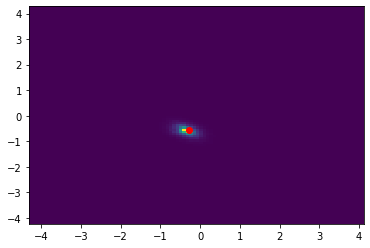

In [10]:
pars = prior.sample(100000)
lnL = re.lnL(obs0, pars)
plt.hist2d(pars['A'], pars['B'], weights = np.exp(lnL[('A', 'B')]), bins = 100, density = True);
plt.scatter(par0['A'], par0['B'], marker='o', color='r')

In [11]:
sd = re.state_dict()
swyft.RatioEstimator.from_state_dict(sd)

In [12]:
prior2 = prior.get_masked(obs0, re)

In [13]:
sd = prior2.state_dict()
Prior.from_state_dict(sd)

In [18]:
cache.grow(prior2, 3000)
cache.simulate(model)

Simulate:   1%|          | 11/1935 [00:00<00:18, 102.30it/s]

Adding 1935 new samples. Run simulator!


Simulate: 100%|██████████| 1935/1935 [00:18<00:00, 103.19it/s]


In [19]:
indices = cache.sample(prior2, N)
points = swyft.Points(cache, indices, noise)

In [20]:
re = swyft.RatioEstimator([("A"), ("B"), ("A", "B")], device=DEVICE)
re.train(points, max_epochs=10, batch_size=16, lr_schedule=[1e-3, 3e-4, 1e-4, 3e-5])

n_features = 5
Start training
LR iteration 0
Validation loss: 12.31074047088623
Validation loss: 11.054708480834961
Validation loss: 8.954777240753174
Validation loss: 6.87696647644043
Validation loss: 6.718576431274414
Validation loss: 6.915428638458252
Total epochs: 6
LR iteration 1
Validation loss: 6.480524301528931
Validation loss: 5.866288423538208
Validation loss: 5.668644070625305
Validation loss: 6.1691224575042725
Total epochs: 4
LR iteration 2
Validation loss: 6.001288652420044
Validation loss: 5.47780442237854
Validation loss: 5.927480220794678
Total epochs: 3
LR iteration 3
Validation loss: 5.66150963306427
Validation loss: 5.765381336212158
Total epochs: 2


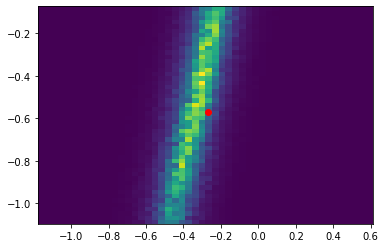

In [21]:
pars = prior2.sample(100000)
lnL = re.lnL(obs0, pars)
plt.hist2d(pars['A'], pars['B'], weights = np.exp(lnL[('A', 'B')]), bins = 50, density = True);
plt.scatter(par0['A'], par0['B'], marker='o', color='r')